In [2]:
# === Basis-Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning / Deep Learning ===
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50V2, EfficientNetB0
)

# === Tools ===
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1


Datensatzordner: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1\PlantVillage\PlantVillage
Anzahl Klassen: 15
Klassen-Beispiele: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold']

Bilder pro Klasse:
Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___healthy: 152
Potato___Late_blight: 1000
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_healthy: 1591
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_mosaic_virus: 373
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208


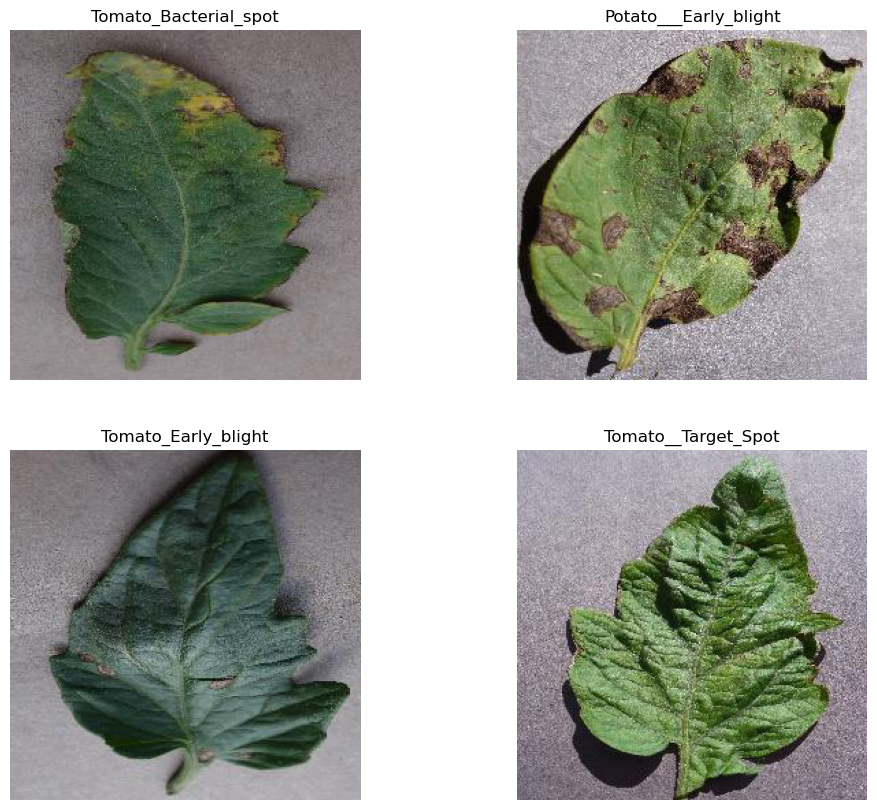

In [5]:
import random
from PIL import Image

# Richtiger PlantVillage-Datenordner
dataset_dir = os.path.join(path, "PlantVillage", "PlantVillage")

print("Datensatzordner:", dataset_dir)

# --- Klassenordner ---
folders = [
    f for f in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, f))
]

print("Anzahl Klassen:", len(folders))
print("Klassen-Beispiele:", folders[:10])

# --- Bilder pro Klasse zählen ---
class_counts = {}
for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    class_counts[cls] = len(images)

print("\nBilder pro Klasse:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# --- Beispielbilder anzeigen ---
sample_classes = random.sample(folders, 4)

plt.figure(figsize=(12, 10))
for i, cls in enumerate(sample_classes):
    cls_folder = os.path.join(dataset_dir, cls)
    images = [f for f in os.listdir(cls_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    img_name = random.choice(images)
    img_path = os.path.join(cls_folder, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


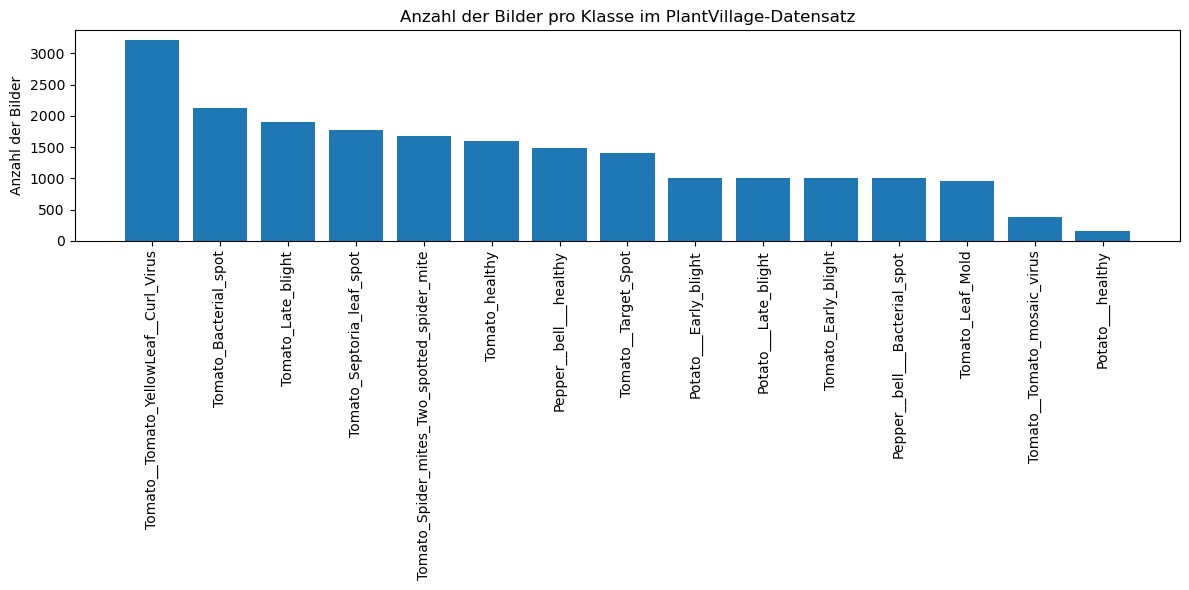

In [6]:
# DataFrame aus Klassenanzahl erstellen
df_classes = pd.DataFrame(
    class_counts.items(), columns=["Class", "Image Count"]
)

# sortieren für bessere Lesbarkeit
df_classes = df_classes.sort_values(by="Image Count", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_classes["Class"], df_classes["Image Count"])
plt.xticks(rotation=90)
plt.ylabel("Anzahl der Bilder")
plt.title("Anzahl der Bilder pro Klasse im PlantVillage-Datensatz")
plt.tight_layout()
plt.show()

In [7]:
image_sizes = []
color_modes = []

sample_classes = random.sample(folders, min(5, len(folders)))

for cls in sample_classes:
    cls_folder = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    for img_name in random.sample(images, min(10, len(images))):
        img_path = os.path.join(cls_folder, img_name)
        img = Image.open(img_path)
        image_sizes.append(img.size)
        color_modes.append(img.mode)

# Ergebnisse anzeigen
unique_sizes = set(image_sizes)
unique_modes = set(color_modes)

print("Beispielhafte Bildgrößen:", list(unique_sizes)[:5])
print("Beispielhafte Farbmodi:", unique_modes)

# Durchschnittliche Bildgröße berechnen
avg_width = int(np.mean([size[0] for size in image_sizes]))
avg_height = int(np.mean([size[1] for size in image_sizes]))

print(f"Bildbreite: {avg_width:.1f}px")
print(f"Bildhöhe: {avg_height:.1f}px")


Beispielhafte Bildgrößen: [(256, 256)]
Beispielhafte Farbmodi: {'RGB'}
Bildbreite: 256.0px
Bildhöhe: 256.0px


In [ ]:
# Bildparameter
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# ImageDataGenerator mit Normalisierung und Validation-Split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2 # 80% Training, 20% Validierung
)

# Trainingsdaten
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED
)

# Validierungsdaten
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED
)

print("Anzahl Klassen:", train_generator.num_classes)
print("Klassenlabels:", train_generator.class_indices)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Anzahl Klassen: 15
Klassenlabels: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


CNN-Modell

In [9]:
num_classes = train_generator.num_classes

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Klassifikationskopf
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')    
])

# Kompilieren des Modells
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\thien\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,249,423 (84.87 MB)

 Trainable params: 22,248,975 (84.87 MB)

 Non-trainable params: 448 (1.75 KB)

Training des Modells

In [11]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "baseline_cnn_best_model.h5",
    monitor='val_loss',
    save_best_only=True
)

# Training des Modells
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2149 - loss: 2.4560

517/517 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.2204 - loss: 2.4641 - val_accuracy: 0.1009 - val_loss: 3.3303
Epoch 2/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.2354 - loss: 2.2939 - val_accuracy: 0.0941 - val_loss: 117.8690
Epoch 3/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.2564 - loss: 2.3080

517/517 ━━━━━━━━━━━━━━━━━━━━ 502s 971ms/step - accuracy: 0.2593 - loss: 2.2545 - val_accuracy: 0.3491 - val_loss: 2.2386
Epoch 4/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 485s 937ms/step - accuracy: 0.2707 - loss: 2.4345 - val_accuracy: 0.1407 - val_loss: 10.1694
Epoch 5/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.2412 - loss: 2.3413 - val_accuracy: 0.2567 - val_loss: 2.7454
Epoch 6/6
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2663 - loss: 2.1879

517/517 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.2759 - loss: 2.1576 - val_accuracy: 0.3991 - val_loss: 1.9801


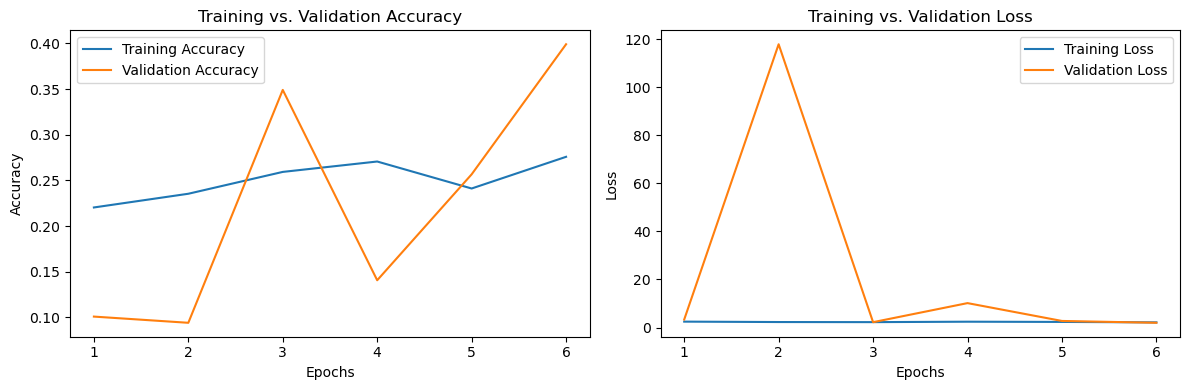

In [12]:
# Accuracy und Loss auslesen
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(12, 4))

# Accuracy-Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

# Loss-Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.tight_layout()
plt.show()